In [1]:
import random
import math

import numpy as np
import matplotlib.pyplot as plt

# Resolviendo Sudokus
Inteligencia Artificial - Facundo A. Lucianna - CEIA - FIUBA

Las reglas de Sudoku son simples y finitas. Llena las celdas vacías de tal forma que las columnas, filas y cajas de 3x3 contengan todos los dígitos del 1 a 9 sin repetirse. Por ejemplo:

![sudoku](./sudoku_1.png)

# Implementando conceptos básicos

Basándonos en el trabajo de [Peter Norvig](https://github.com/norvig/pytudes/blob/main/ipynb/Sudoku.ipynb), vamos a establecer los conceptos claves de Sudokus:

- **Dígitos**: Los dígitos son los números del `1` al `9`
- **Filas**: Por convención las 9 filas tienen etiquetas `'A'` a `'I'` (de arriba a abajo)
- **Columnas**: Por convención las 9 columnas tienen etiquetas `'1'` a `'9'` (de izquierda a derecha)
- **Celda**: Una celda es nombrado por la concatenación de la etiqueta de la fila y columna, por ejemplo, `'A9'` es la celda del ángulo de arriba a la derecha.
    - `squares`: Es una tupla de todos 81 cuadrados.
- **Celda fijas**: Son las celdas que se dan resueltas al principio. Son los valores en negro del diagrama de arriba.
    - `fixed_squares`: Es un diccionario que tiene como key la posición de las celdas fijas y como valor el dígito que le corresponde.
- **Cajas**: Las 9 cajas son cuadrados de 3x3 dentro de la grilla (resaltado con líneas negras en el diagrama)
    - `all_boxes`: Es una lista de las 9 cajas.
- **Unidad**: Una unidad es una fila, columna o caja. Cada unidad es una tupla de 9 celdas.
    - `all_units`: Es una lista de las 27 unidades
- **Estado**: Es el llenado de una grilla de Sudoku completa, usando los 9 dígitos, uno por celda.
    - Los estados se representan con diccionarios que tiene como key la posición a las celdas y como valor el dígito que se le asignó.
- **Solución**: Una grilla es válida como solución si cada unidad está llenada con los 9 dígitos, uno por celda, sin repetirse en cada unidad.
- **Vecinos**: Un vecino de un estado A son aquellos estados que para una unidad una celda haya intercambiado el valor con otra celda de la misma unidad. También son vecinos aquellos estados que el valor de una sola celda tenga un valor diferente. Estas reglas solo se aplican a las celdas que no son fijas.

A continuación definimos las funciones que nos van a servir, tales como la inicializacion de un estado, de creacion de vecinos y para ver si un estado es solución.

In [2]:
def cross(A, B) -> tuple:
    """Producto cruzado de strings en A y strings en B"""
    return tuple(a + b for a in A for b in B)

def print_state(state_to_print: dict, rows: str, cols: str) -> None:
    """
    Imprime el estado actual del Sudoku.

    Args:
        state_to_print (dict): Diccionario que representa el tablero de Sudoku, 
        con claves como coordenadas (e.g., "A1", "B2") y valores como los números 
        en las casillas correspondientes.
        rows (str): String con el nombre de las filas
        cols (str): String con el nombre de las columnas

    """
    size = int(len(rows) ** 0.5)  # Tamaño de las cajas (e.g., 2 para 2x2, 3 para 3x3)
    horizontal_line = "+".join(["-" * (size * 3)] * size)
    horizontal_line = "*" + horizontal_line + "*"
    print(horizontal_line)

    for index_row, row in enumerate(rows):
        print("|", end="")
        for col_index, col in enumerate(cols):
            print(f" {state_to_print[row + col]} ", end="")
            if (col_index + 1) % size == 0 and col_index < len(cols) - 1:
                print("|", end="")
        print("|")
        if (index_row + 1) % size == 0 and index_row < len(rows) - 1:
            print(horizontal_line)

    print(horizontal_line)


def return_neib_states(state: dict, fixed_squares: dict, rows: str, all_units: list, squares: list) -> list:
    """
    Retorna todos los estados vecinos del estado actual del Sudoku.

    Args:
        state (dict): Diccionario que representa el tablero de Sudoku actual.
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku.
        rows (str): String con el nombre de las filas
        all_units (list): Lista con todas las unidades (filas, columnas y cajas)
        squares (list): Lista con todas las celdas.

    Returns:
        list: Una lista de diccionarios que representan los estados vecinos.
    """
    
    size = len(rows) # Tamaño de la fila
        
    all_neib = []
    
    # Intercambiar los valores de dos casillas en la misma unidad
    for unit in all_units:
        for index, cell in enumerate(unit):
            if cell in fixed_squares:
                continue
            for second_cell in unit[index + 1:]:
                if second_cell not in fixed_squares:
                    new_neib = state.copy()
                    new_neib[cell], new_neib[second_cell] = new_neib[second_cell], new_neib[cell]
                    all_neib.append(new_neib)
    
    # Cambiar el valor de una casilla
    for cell in squares:
        if cell not in fixed_squares:
            for value in range(1, size+1):
                if state[cell] != value:
                    new_neib = state.copy()
                    new_neib[cell] = value
                    all_neib.append(new_neib)
                
    return all_neib

def is_solution(state: dict, solution: dict) -> bool:
    """Es el estado solución del Sudoku?"""
    return all(solution[s] == state[s] for s in squares)


def init_state(fixed_squares, rows: str, cols: str, max_value=9):
    """
    Inicializa un estado aleatorio para el Sudoku.

    Args:
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku, 
        con claves como coordenadas (e.g., "A1", "B2") y valores como los números 
        fijos correspondientes.
        max_value (int, optional): Valor máximo que se puede insertar como digito en el 
        Sudoku. Por defecto es 9.

    Returns:
        dict: Diccionario que representa el tablero de Sudoku generado aleatoriamente,
        con las casillas fijas y las casillas vacías llenas con valores aleatorios
        que cumplen la restricción de que no puede haber números repetidos en las filas.
    """

    # Inicializamos el tablero del Sudoku
    puzzle = {}

    # Iteramos sobre cada fila del tablero
    for row in rows:
        # Creamos una lista de columnas disponibles para cada fila
        available_columns = [num for num in range(1, max_value+1)]
        
        # Eliminamos los números que ya están en la fila
        for col in cols:
            if row + col in fixed_squares:
                available_columns.remove(int(col))
                
        # Asignamos valores aleatorios a las casillas vacías en la fila
        for col in available_columns:
            square = row + str(col)
            # Elegimos aleatoriamente un número disponible para la casilla
            value = random.choice(range(1, max_value+1))
            puzzle[square] = value
    
    puzzle.update(fixed_squares)
    return puzzle

----
# Usando métodos de optimización

Ahora vamos a usar los métodos que vimos en clase para resolver Sudokus. Recordemos que aqui no nos importa el camino que nos lleva, sino que buscamos encontrar la solución independientemente 
del camino que tomamos. Para ello usaremos algoritmos de búsqueda local. 

Empezaremos por el más básico (y famoso)...

## Gradiente descendiente o ascendente

Este algoritmo que continuamente se mueve en dirección de mayor valor decreciente o creciente. Termina la búsqueda en donde ningún vecino está más bajo. Este algoritmo no miras más allá de lo 
que tiene de los vecinos. Para este caso, definimos a los vecinos como:

*Un vecino de un estado A son aquellos estados que para una unidad una celda haya intercambiado el valor con otra celda de la misma unidad. También son vecinos aquellos estados que el valor de una sola celda tenga un valor diferente. Estas reglas solo se aplican a las celdas que no son fijas.* 

### Sudoku de 2x2:

Dado que queremos arrancar de más sencillo a más complejo, empecemos resolviendo Sudokus de 2x2, particularmente el siguiente:

![sudoku 2x2](./sudoku_2.png)

In [3]:
digits = '1234'
rows = 'ABCD'
cols = digits
squares = cross(rows, cols)

all_boxes = [cross(rs, cs)  for rs in ('AB','CD') for cs in ('12','34')]
all_units = [cross(rows, c) for c in cols] + [cross(r, cols) for r in rows] + all_boxes

fixed_squares = {
    'A1': 1, 'A2': 4, 
    'B4': 4, 
    'C1': 2, 'C4': 1,
    'D1': 4, 'D2': 1, 'D4': 3,
}

solution = {
    'A1': 1, 'A2': 4, 'A3': 3, 'A4': 2, 
    'B1': 3, 'B2': 2, 'B3': 1, 'B4': 4,
    'C1': 2, 'C2': 3, 'C3': 4, 'C4': 1, 
    'D1': 4, 'D2': 1, 'D3': 2, 'D4': 3, 
}

Antes de aplicar el algoritmo, necesitamos definir nuestra función de costo a optimizar. Para este caso vamos a definir una función que para cada 
*unidad* si un dígito está repetido más de una vez o no se encuentra, le vamos sumando un factor de penalidad. Por lo que si es la solución correcta, 
para cada fila, cada columna y cada caja, nunca un dígito esta más de una vez, y por consiguiente, su valor al pasar por esta función es cero y es el 
único y minimo valor.


In [4]:
def cost_function(state: dict, all_units: list, max_value = 9) -> int:
    """
    Calcula la función de costo del estado actual del Sudoku.

    Args:
        state (dict): Diccionario que representa el tablero de Sudoku actual.
        all_units (list): Lista con todas las unidades (filas, columnas y cajas)
        max_value (int, optional): Valor máximo que se puede insertar como digito en el 
        Sudoku. Por defecto es 9.

    Returns:
        int: El valor de la función de costo.
    """
    penalization = 0
    for unit in all_units:
        values = [state[cell] for cell in unit]
        for i in range(1, max_value + 1):
            value_count = values.count(i)
            if value_count != 1:
                # Si el elemento no está o está dos veces, le sumamos una penalización
                penalization += 0.05
                if value_count > 2:
                    # Pero si esta más de dos veces, lo penalizamos más duro.
                    penalization += 0.05 * (value_count - 2)
    return penalization

Ya con la función de costo, podemos armar la función de gradiente descendiente

In [5]:
def gradient_descent_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_value=9, max_iterations=100):
    """
    Realiza la optimización del Sudoku utilizando el método de descenso de gradiente.

    Args:
        initial_state (dict): El estado inicial del Sudoku.
        rows (str): String con el nombre de las filas
        all_units (list): Lista con todas las unidades (filas, columnas y cajas)
        squares (list): Lista con todas las celdas.
        max_value (int, optional): El valor de dígito máximo permitido en el Sudoku. 
                                   Para (2x2 es 4, para 3x3 es 9). Por defecto es 9.
        max_iterations (int, optional): El número máximo de iteraciones permitidas. 
                                        Por defecto es 100.
    Returns:
        dict: El mejor estado encontrado después de la optimización.
        bool: Si es solución devuelve True
    """
    best_state = initial_state
    
    # Iteramos hasta max_iterations 
    for iteration in range(max_iterations):
        
        # Calculamos la función de costo para el estado actual
        cost_state = cost_function(best_state, all_units, max_value=max_value)
        
        # Si es solución, tiene que tener costo cero, por lo que termina 
        if cost_state == 0:
            print("Encontramos la solución")
            return best_state, True
        
        # Obtenemos a los vecinos más cercanos 
        neib_states = return_neib_states(best_state, fixed_squares, rows, all_units, squares)
        
        # Calculamos el delta del costo entre el estado actual y sus vecinos
        neib_energy_list = [cost_function(neib_state, all_units, max_value=max_value) - cost_state for neib_state in neib_states]
        
        # Obtenemos el índice de la lista de estados vecinos que tengan el mínimo valor y que además sea negativo
        # significando que estamos descendiendo en la función en la dirección de máximo descenso.
        index_min_energy = [i for i, x in enumerate(neib_energy_list) if x < 0]
        
        # Si no tenemos ningún índice, significa que ya no hay más 
        # descenso, retornamos lo mejor que llegó el método
        if not index_min_energy:
            return best_state, False
        
        # Si no, elegimos una dirección al azar de los máximos cambios
        index_sel = random.choice(index_min_energy)
        best_state = neib_states[index_sel]
    
    # Si terminamos las iteraciones, retornamos nuestro mejor resultado
    return best_state, False

Creado el algoritmo, aplicamos para encontrar la solución:

In [6]:
# Inicializamos el primer estado al azar
initial_state = init_state(fixed_squares, rows, cols, max_value=4)    

# Aplicamos gradiente descendiente
last_state, is_sol = gradient_descent_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_value=4, max_iterations=100)

print(f"Valor de costo inicial {cost_function(initial_state, all_units, max_value=4)} y final {cost_function(last_state, all_units, max_value=4)}")
print("Primer estado:")
print_state(initial_state, rows, cols)

print("Último estado encontrado:")
print_state(last_state, rows, cols)
# Verificamos si el estado encontrado es realmente solución con 
# la solución que ya tenemos
if is_sol:
    if is_solution(last_state, solution):
        print("El estado que encontramos verifica que realmente es la solución")
        print("Solución:")
        print_state(solution, rows, cols)

Encontramos la solución
Valor de costo inicial 1.7000000000000008 y final 0
Primer estado:
*------+------*
| 1  4 | 4  4 |
| 1  2 | 1  4 |
*------+------*
| 2  1 | 1  1 |
| 4  1 | 1  3 |
*------+------*
Último estado encontrado:
*------+------*
| 1  4 | 3  2 |
| 3  2 | 1  4 |
*------+------*
| 2  3 | 4  1 |
| 4  1 | 2  3 |
*------+------*
El estado que encontramos verifica que realmente es la solución
Solución:
*------+------*
| 1  4 | 3  2 |
| 3  2 | 1  4 |
*------+------*
| 2  3 | 4  1 |
| 4  1 | 2  3 |
*------+------*


### Sudoku de 3x3:

Subamos la dificultad, ahora intentemos resolver este Sudoku de 3x3:

![sudoku](./sudoku_1.png)

In [7]:
rows = 'ABCDEFGHI'
digits = '123456789'
cols = digits
squares = cross(rows, cols)

all_boxes = [cross(rs, cs)  for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')]
all_units = [cross(rows, c) for c in cols] + [cross(r, cols) for r in rows] + all_boxes

fixed_squares = {
    'A1': 3, 'A3': 4, 'A4': 5, 'A5': 6, 'A7': 9,
    'B1': 1, 'B2': 8, 'B3': 5, 'B6': 9, 'B7': 7,
    'C5': 7, 'C6': 8, 'C7': 4, 'C8': 1, 'C9': 5,
    'D2': 2, 'D5': 1, 'D8': 4, 'D9': 9,
    'E2': 4, 'E3': 9, 'E5': 5, 
    'F3': 1, "F4": 9, "F5": 8, "F7": 6, "F8": 7,
    'G1': 4, 'G2': 9, 'G5': 3, 'G9': 7, 
    'H2': 1, 'H3': 8, 'H4': 7, 'H5': 4, 'H6': 5, 'H9': 6,
    'I8': 8,
}

solution = {
    'A1': 3, 'A2': 7, 'A3': 4, 'A4': 5, 'A5': 6, 'A6': 1, 'A7': 9, 'A8': 2, 'A9': 8,
    'B1': 1, 'B2': 8, 'B3': 5, 'B4': 4, 'B5': 2, 'B6': 9, 'B7': 7, 'B8': 6, 'B9': 3,
    'C1': 9, 'C2': 6, 'C3': 2, 'C4': 3, 'C5': 7, 'C6': 8, 'C7': 4, 'C8': 1, 'C9': 5,
    'D1': 8, 'D2': 2, 'D3': 7, 'D4': 6, 'D5': 1, 'D6': 3, 'D7': 5, 'D8': 4, 'D9': 9,
    'E1': 6, 'E2': 4, 'E3': 9, 'E4': 2, 'E5': 5, 'E6': 7, 'E7': 8, 'E8': 3, 'E9': 1,
    'F1': 5, 'F2': 3, 'F3': 1, 'F4': 9, 'F5': 8, 'F6': 4, 'F7': 6, 'F8': 7, 'F9': 2,
    'G1': 4, 'G2': 9, 'G3': 6, 'G4': 8, 'G5': 3, 'G6': 2, 'G7': 1, 'G8': 5, 'G9': 7,
    'H1': 2, 'H2': 1, 'H3': 8, 'H4': 7, 'H5': 4, 'H6': 5, 'H7': 3, 'H8': 9, 'H9': 6,
    'I1': 7, 'I2': 5, 'I3': 3, 'I4': 1, 'I5': 9, 'I6': 6, 'I7': 2, 'I8': 8, 'I9': 4,
}

Apliquemos gradiente descendiente:

In [8]:
# Inicializamos el primer estado al azar
initial_state = init_state(fixed_squares, rows, cols)    

# Aplicamos gradiente descendiente
last_state, is_sol = gradient_descent_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_iterations=100)

print(f"Valor de costo inicial {cost_function(initial_state, all_units)} y final {cost_function(last_state, all_units)}")
print("Primer estado:")
print_state(initial_state, rows, cols)

print("Último estado encontrado:")
print_state(last_state, rows, cols)
# Verificamos si el estado encontrado es realmente solución con 
# la solución que ya tenemos
if is_sol:
    if is_solution(last_state, solution):
        print("El estado que encontramos verifica que realmente es la solución")
        print("Solución:")
        print_state(solution, rows, cols)

Valor de costo inicial 7.599999999999981 y final 1.4000000000000006
Primer estado:
*---------+---------+---------*
| 3  4  4 | 5  6  1 | 9  4  7 |
| 1  8  5 | 7  1  9 | 7  1  4 |
| 7  9  1 | 2  7  8 | 4  1  5 |
*---------+---------+---------*
| 3  2  7 | 5  1  2 | 4  4  9 |
| 8  4  9 | 2  5  5 | 7  1  1 |
| 9  3  1 | 9  8  2 | 6  7  9 |
*---------+---------+---------*
| 4  9  9 | 6  3  5 | 8  3  7 |
| 9  1  8 | 7  4  5 | 7  8  6 |
| 1  4  4 | 1  2  5 | 3  8  8 |
*---------+---------+---------*
Último estado encontrado:
*---------+---------+---------*
| 3  7  4 | 5  6  1 | 9  2  8 |
| 1  8  5 | 3  2  9 | 7  6  4 |
| 2  9  6 | 4  7  8 | 4  1  5 |
*---------+---------+---------*
| 5  2  7 | 6  1  4 | 8  4  9 |
| 8  4  9 | 7  5  3 | 2  5  1 |
| 4  3  1 | 9  8  2 | 6  7  3 |
*---------+---------+---------*
| 4  9  2 | 8  3  6 | 5  9  7 |
| 9  1  8 | 7  4  5 | 1  3  6 |
| 6  5  3 | 1  9  7 | 4  8  2 |
*---------+---------+---------*


Vemos que se está quedando en un minimo relativo, por lo que no puede llegar a cero. Intentemos ver si corriendo el algoritmos varias veces, iniciando al 
azar, llegamos a la solución:

In [9]:
for j in range(1000):
    initial_state = init_state(fixed_squares, rows, cols)        
    last_state, is_sol = gradient_descent_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_iterations=100)
    
    if is_sol:
        break
        
if is_sol:
    print_state(last_state, rows, cols)
    if is_solution(last_state, solution):
        print(f"En la iteración {j} se encontró la solución.")

Encontramos la solución
*---------+---------+---------*
| 3  7  4 | 5  6  1 | 9  2  8 |
| 1  8  5 | 4  2  9 | 7  6  3 |
| 9  6  2 | 3  7  8 | 4  1  5 |
*---------+---------+---------*
| 8  2  7 | 6  1  3 | 5  4  9 |
| 6  4  9 | 2  5  7 | 8  3  1 |
| 5  3  1 | 9  8  4 | 6  7  2 |
*---------+---------+---------*
| 4  9  6 | 8  3  2 | 1  5  7 |
| 2  1  8 | 7  4  5 | 3  9  6 |
| 7  5  3 | 1  9  6 | 2  8  4 |
*---------+---------+---------*
En la iteración 3 se encontró la solución.


A veces se llega a la solución (si ejecutan la celda anterior, a veces encuentra la solución a veces no), pero la mayoría de las veces no, por lo que podemos
probar otro algoritmo.

Nota: Se deja a los alumnos a implementar alguna variante de este algoritmo.

### Simmulated annealing 

La idea aquí es que en general se vaya a un estado de menor energía, pero por azar a veces pueda ir en dirección contraria, buscando de esa forma salir de 
un mínimo local. La idea es sacudir para que salga del mínimo local, pero que no se nos vaya tan lejos que no podamos llegar al mínimo global.

Este algoritmo arranca con mucha temperatura y a medida que avanza, se va enfriando, de igual forma que el metal.

In [10]:
def simulated_annealing_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_value=9, max_iterations=100, 
                               initial_temperature=1.0, cooling_rate=0.95):
    """
    Realiza la optimización del Sudoku utilizando Simulated Annealing.

    Args:
        initial_state (dict): El estado inicial del Sudoku.
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku.
        rows (str): String con el nombre de las filas.
        all_units (list): Lista con todas las unidades (filas, columnas y cajas).
        squares (list): Lista con todas las celdas.
        max_value (int, optional): El valor de dígito máximo permitido en el Sudoku. 
                                   Para (2x2 es 4, para 3x3 es 9). Por defecto es 9.
        max_iterations (int, optional): El número máximo de iteraciones permitidas. 
                                        Por defecto es 100.
        initial_temperature (float, optional): La temperatura inicial para el algoritmo de Simulated Annealing.
        cooling_rate (float, optional): La tasa de enfriamiento para el algoritmo de Simulated Annealing.

    Returns:
        dict: El mejor estado encontrado después de la optimización.
        bool: Si es solución devuelve True.
    """
    current_state = initial_state
    best_state = initial_state
    temperature = initial_temperature

    # Iteramos hasta max_iterations
    for iteration in range(max_iterations):

        # Si es solución, terminamos.
        if is_solution(solution, best_state):
            return best_state, True

        # Calculamos la función de costo para el estado actual
        current_cost = cost_function(current_state, all_units, max_value=max_value)

        # Obtenemos un estado vecino aleatorio
        neib_state = random.choice(return_neib_states(current_state, fixed_squares, rows, all_units, squares))

        # Calculamos la función de costo para el estado vecino
        neib_cost = cost_function(neib_state, all_units, max_value=max_value)

        # Calculamos el delta de costo entre el estado actual y el vecino
        delta_cost = neib_cost - current_cost

        # Si el vecino es mejor o se acepta según la probabilidad de Boltzmann, actualizamos el estado actual
        if delta_cost < 0:
            current_state = neib_state
        else:
            if random.random() < math.exp(-delta_cost / temperature):
                current_state = neib_state

        # Si el nuevo estado es mejor que el mejor estado encontrado hasta ahora, actualizamos el mejor estado
        if cost_function(current_state, all_units, max_value=max_value) < cost_function(best_state, all_units, max_value=max_value):
            best_state = current_state

        # Enfriamos la temperatura
        temperature *= cooling_rate
        
        # if iteration % (max_iterations // 10) == 0:
        #     print(f"Temperature {temperature}")

    # Si terminamos las iteraciones, retornamos el mejor resultado encontrado
    return best_state, False

Si observamos a diferencia de gradiente descendiente, no necesariamente elegimos la dirección de máximo decrecimiento, sino alguno en cualquier dirección, 
inclusive en dirección contraria (en donde el costo aumenta) con cierto valor dado por la probabilidad de Boltzmann.

**Nota**: Si adaptamos este algoritmo para que no tenga temperatura, podríamos implementar gradiente descendiente estocástico.

Aquí aplicamos el método:

In [11]:
for j in range(1000):
    # Inicializamos el primer estado al azar
    initial_state = init_state(fixed_squares, rows, cols)    

    # Aplicamos gradiente descendiente
    last_state, is_sol = simulated_annealing_sudoku(initial_state, fixed_squares, rows, all_units, squares, max_iterations=5000)
    
    if is_sol:
        break
        
if is_sol:
    if is_solution(last_state, solution):
        print(f"En la iteración {j} se encontró la solución.")

print(f"Valor de costo inicial {cost_function(initial_state, all_units)} y final {cost_function(last_state, all_units)}")
print("Primer estado:")
print_state(initial_state, rows, cols)

print("Último estado encontrado:")
print_state(last_state, rows, cols)
# Verificamos si el estado encontrado es realmente solución con 
# la solución que ya tenemos
if is_sol:
    if is_solution(last_state, solution):
        print("El estado que encontramos verifica que realmente es la solución")
        print("Solución:")
        print_state(solution, rows, cols)

En la iteración 0 se encontró la solución.
Valor de costo inicial 7.099999999999983 y final 0
Primer estado:
*---------+---------+---------*
| 3  6  4 | 5  6  4 | 9  2  9 |
| 1  8  5 | 6  6  9 | 7  9  1 |
| 3  8  3 | 3  7  8 | 4  1  5 |
*---------+---------+---------*
| 5  2  3 | 6  1  3 | 2  4  9 |
| 9  4  9 | 3  5  3 | 3  2  4 |
| 1  6  1 | 9  8  2 | 6  7  4 |
*---------+---------+---------*
| 4  9  7 | 8  3  7 | 2  9  7 |
| 4  1  8 | 7  4  5 | 6  6  6 |
| 2  8  9 | 6  7  3 | 8  8  4 |
*---------+---------+---------*
Último estado encontrado:
*---------+---------+---------*
| 3  7  4 | 5  6  1 | 9  2  8 |
| 1  8  5 | 4  2  9 | 7  6  3 |
| 9  6  2 | 3  7  8 | 4  1  5 |
*---------+---------+---------*
| 8  2  7 | 6  1  3 | 5  4  9 |
| 6  4  9 | 2  5  7 | 8  3  1 |
| 5  3  1 | 9  8  4 | 6  7  2 |
*---------+---------+---------*
| 4  9  6 | 8  3  2 | 1  5  7 |
| 2  1  8 | 7  4  5 | 3  9  6 |
| 7  5  3 | 1  9  6 | 2  8  4 |
*---------+---------+---------*
El estado que encontramos verific

Con este método se vuelve más fácil encontrar la solución. Con gradiente descendiente, tuvimos que repetir muchísimas veces el experimento hasta que 
le pegamos, en cambio, en general con unas pocas ejecuciones, con **Simmulated Annealing** llegamos a la solución.

###  Local Beam

Buscar desde un estado inicial únicamente es una medida un poco extrema de ahorro de memoria. En cambio, búsqueda local beam guarda la información de 
**k** estados y sobre ellos realiza la búsqueda independientemente. Estos se inician al azar.

En cada paso se generan sucesores de los **k** estados. Si alguno cumple el objetivo, se termina, en cambio, si no, se seleccionan los **k** mejores 
sucesores de la lista. A simple vista pareciera lo mismo de correr **k** veces a gradiente descendiente, pero a diferencia de esto es que entre los procesos 
de búsquedas hay pase de información:

*Si un estado genera varios sucesores buenos y los otros k-1 estados generan sucesores malos, entonces el efecto es que el primer estado abandona la 
búsqueda de los otros y se queda con los sucesores del primer estado.*

In [12]:
def local_beam_search(initial_generation, fixed_squares, rows, all_units, squares, max_value=9, max_iterations=100):
    """
    Realiza la optimización del Sudoku utilizando búsqueda por Local Beam.

    Args:
        initial_generation (list): Lista con estados iniciales del Sudoku.
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku.
        rows (str): String con el nombre de las filas.
        all_units (list): Lista con todas las unidades (filas, columnas y cajas).
        squares (list): Lista con todas las celdas.
        max_value (int, optional): El valor de dígito máximo permitido en el Sudoku. 
                                   Para 2x2 es 4, para 3x3 es 9. Por defecto es 9.
        max_iterations (int, optional): El número máximo de iteraciones permitidas. 
                                        Por defecto es 100.

    Returns:
        dict: El mejor estado encontrado después de la optimización.
        bool: Indica si el estado mejor encontrado es una solución válida.
    """
    # Inicializamos para poder arrancar
    best_state = initial_generation[0] 
    best_cost = cost_function(best_state, all_units, max_value=max_value)
    
    number_population = len(initial_generation)
    current_population = initial_generation.copy()
    
    # Iteramos hasta max_iterations
    for iteration in range(max_iterations):

        # Para cada uno de la generación, calculamos su función de costo
        actual_cost_list = []
        for index in range(number_population):
            state = current_population[index]
            cost = cost_function(state, all_units, max_value=max_value)
            actual_cost_list.append(cost)
            if cost < best_cost:
                best_state = state
                best_cost = cost
                print(f"El mejor costo es: {best_cost} en la iteración {iteration}")
            
        # Si es solución, terminamos.
        if is_solution(solution, best_state):
            return best_state, True

        # Obtenemos a todos los vecinos posibles y sus costos
        all_neib = []
        all_cost = []
        for index, state in enumerate(current_population):
            actual_neib = return_neib_states(state, fixed_squares, rows, all_units, squares)
            all_neib += actual_neib
            all_cost += [cost_function(state_neib, all_units, max_value=max_value) - actual_cost_list[index] for state_neib in actual_neib]
        
        # Ordenamos a los vecinos en función del costo 
        index_neib_list = sorted(range(len(all_cost)), key=lambda x: all_cost[x])
        all_neib = [all_neib[k] for k in index_neib_list]
                  
        # Nos quedamos con los k de la generación 
        current_population = all_neib[:number_population]
        
    # Si terminamos las iteraciones, retornamos el mejor resultado encontrado
    return best_state, False

Aquí aplicamos el método para ver si encontramos la solución:

In [13]:
initial_generation = []
for i in range(20):
    initial_generation.append(init_state(fixed_squares, rows, cols))

last_state, is_sol = local_beam_search(initial_generation, fixed_squares, rows, all_units, squares, max_value=9, max_iterations=100)

El mejor costo es: 7.199999999999982 en la iteración 0
El mejor costo es: 6.5999999999999845 en la iteración 0
El mejor costo es: 6.399999999999985 en la iteración 0
El mejor costo es: 6.199999999999986 en la iteración 0
El mejor costo es: 5.999999999999987 en la iteración 2
El mejor costo es: 5.699999999999988 en la iteración 5
El mejor costo es: 5.399999999999989 en la iteración 6
El mejor costo es: 5.09999999999999 en la iteración 7
El mejor costo es: 4.799999999999991 en la iteración 8
El mejor costo es: 4.499999999999992 en la iteración 9
El mejor costo es: 4.199999999999993 en la iteración 10
El mejor costo es: 3.899999999999994 en la iteración 11
El mejor costo es: 3.599999999999995 en la iteración 12
El mejor costo es: 3.2999999999999963 en la iteración 13
El mejor costo es: 3.099999999999997 en la iteración 14
El mejor costo es: 2.799999999999998 en la iteración 15
El mejor costo es: 2.5999999999999988 en la iteración 16
El mejor costo es: 2.3999999999999995 en la iteración 17

In [14]:
print("Último estado encontrado:")
print_state(last_state, rows, cols)
# Verificamos si el estado encontrado es realmente solución con 
# la solución que ya tenemos
if is_sol:
    if is_solution(last_state, solution):
        print("El estado que encontramos verifica que realmente es la solución")
        print("Solución:")
        print_state(solution, rows, cols)

Último estado encontrado:
*---------+---------+---------*
| 3  7  4 | 5  6  2 | 9  3  8 |
| 1  8  5 | 3  4  9 | 7  6  2 |
| 9  3  6 | 1  7  8 | 4  1  5 |
*---------+---------+---------*
| 8  2  3 | 6  1  7 | 2  4  9 |
| 6  4  9 | 2  5  3 | 8  5  1 |
| 7  5  1 | 9  8  4 | 6  7  3 |
*---------+---------+---------*
| 4  9  5 | 8  3  6 | 1  2  7 |
| 2  1  8 | 7  4  5 | 3  9  6 |
| 3  6  7 | 2  9  1 | 5  8  4 |
*---------+---------+---------*


El problema de este método es que es lento y muy facilmente hace que toda la generación futura vaya hacia una parte pequeña del espacio de búsqueda, lo que
nos genera que nos quedemos en un minimo local. 

Si repetimos este experimento, a veces tenemos suerte y llega a la solución, pero **Simmulated Anneling** es más confiable.

**Nota**: Se deja al alumno implementar la variante de búsqueda de local beam estocástica. Probablemente con este cambio, los resultados mejoren.

###  Algoritmos genéticos

Un algoritmo genético es una variante de la búsqueda local beam estocástica en la que los estados sucesores se generan combinando dos estados 
padres (reproducción). Por lo que para implementar este estado debemos definir varias cosas:

- Forma de codificar el estado como string
- Implementar la reproducción
- Implementar la mutación
- La función de idoneidad, la cual usaremos la función de costo que venimos usando.

In [15]:
def obtain_chromosome_sudoku(state: dict, squares: list) -> str:
    """
    Convierte el estado del Sudoku en un cromosoma.

    Args:
        state (dict): El estado actual del Sudoku.
        squares (list): Lista con todas las celdas del Sudoku.

    Returns:
        str: El cromosoma generado a partir del estado del Sudoku.
    """
    
    chromosome = ""
    for cell in squares:
        chromosome += str(state[cell])
    return chromosome

def obtain_sibling_from_chromosome_sudoku(chromosome: str, squares: list) -> dict:
    """
    Convierte un cromosoma en un estado del Sudoku.

    Args:
        chromosome (str): El cromosoma a ser convertido en estado del Sudoku.
        squares (list): Lista con todas las celdas del Sudoku.

    Returns:
        dict: El estado del Sudoku generado a partir del cromosoma.
    """   
    new_state = {}
    for index, cell in enumerate(squares):
        new_state[cell] = int(chromosome[index]) 
    return new_state

def reproduction_sudoku(chromosome_A: str, chromosome_B: str) -> tuple:
    """
    Realiza el proceso de reproducción entre dos cromosomas del Sudoku.

    Args:
        chromosome_A (str): El primer cromosoma.
        chromosome_B (str): El segundo cromosoma.

    Returns:
        tuple: Una tupla que contiene los dos nuevos cromosomas generados.
    """    
    cut_chrom = random.randint(1, len(chromosome_A) - 2)
    
    sibling_A = chromosome_A[:cut_chrom] + chromosome_B[cut_chrom:]
    sibling_B = chromosome_B[:cut_chrom] + chromosome_A[cut_chrom:]
    
    return sibling_A, sibling_B

def obtain_fixed_pos_in_chromosome_sudoku(fixed_squares: list) -> list:
    """
    Obtiene las posiciones fijas (que no puede mutar) en el cromosoma del Sudoku.

    Args:
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku.
        squares (list): Lista con todas las celdas del Sudoku.

    Returns:
        list: Lista de posiciones fijas en el cromosoma.
    """    
    not_valid_positions = []
    for index, cell in enumerate(squares):
        if cell in fixed_squares:  
            not_valid_positions.append(index) 
    return not_valid_positions

def mutate_chromosome_sudoku_with_temperature(chromosome: str, not_valid_positions: list, temperature: float, max_value: int = 9) -> str:
    """
    Realiza una mutación en el cromosoma del Sudoku utilizando temperatura.

    Args:
        chromosome (str): El cromosoma a ser mutado.
        not_valid_positions (list): Lista de posiciones fijas en el cromosoma.
        temperature (float): El valor de temperatura para controlar la probabilidad de mutación.
        max_value (int, optional): El valor máximo permitido en el Sudoku. Por defecto es 9.

    Returns:
        str: El cromosoma mutado.
    """    
    pos_to_mutate = not_valid_positions[0]
    
    while pos_to_mutate in not_valid_positions:
        pos_to_mutate = random.randint(0, len(chromosome) - 1)
        
    mutation = chromosome[pos_to_mutate]
    while mutation == chromosome[pos_to_mutate]:
        mutation = random.choice(range(max_value + 1))
    
    # Calcula la probabilidad de aceptar la mutación utilizando la temperatura
    mutation_probability = math.exp(-1 * (1 / temperature))
    
    # Si la probabilidad de mutación es mayor que un valor aleatorio, realiza la mutación
    if random.random() < mutation_probability:
        # Realiza la mutación en la posición seleccionada
        if pos_to_mutate == 0:
            return str(mutation) + chromosome[1:]
        elif pos_to_mutate == len(chromosome) - 1:
            return chromosome[:-1] + str(mutation) 
    
        return chromosome[:pos_to_mutate] + str(mutation) + chromosome[pos_to_mutate + 1:]
    
    # Si no se acepta la mutación, devuelve el cromosoma sin cambios
    return chromosome

Con estas definiciones, creemos la función que implementa el algoritmo genético:

In [16]:
def genetic_algorithm_sudoku(initial_generation, fixed_squares, all_units, squares, max_value=9, max_iterations=100, 
                             initial_temperature=1.0, cooling_rate=0.95):
    """
    Realiza la optimización del Sudoku utilizando un algoritmo genético.

    Args:
        initial_generation (list): Lista con estados iniciales del Sudoku.
        fixed_squares (dict): Diccionario que contiene las casillas fijas del Sudoku.
        all_units (list): Lista con todas las unidades (filas, columnas y cajas).
        squares (list): Lista con todas las celdas.
        max_value (int, optional): El valor de dígito máximo permitido en el Sudoku. Por defecto es 9.
        max_iterations (int, optional): El número máximo de iteraciones permitidas. Por defecto es 100.
        initial_temperature (float, optional): La temperatura inicial para controlar la probabilidad de mutación. Por defecto es 1.0.
        cooling_rate (float, optional): La tasa de enfriamiento para ajustar la temperatura en cada iteración. Por defecto es 0.95.

    Returns:
        dict: El mejor estado encontrado después de la optimización.
        bool: Indica si el estado mejor encontrado es una solución válida.
    """    
    temperature = initial_temperature
    best_state = initial_generation[0] 
    best_cost = cost_function(best_state, all_units, max_value=max_value)
    
    number_population = len(initial_generation)
    current_population = initial_generation.copy()
    
    # Obtenemos las posiciones del sudoku que no pueden mutar
    not_valid_positions = obtain_fixed_pos_in_chromosome_sudoku(fixed_squares)
    
    # Iteramos hasta max_iterations
    for iteration in range(max_iterations):
    
        # Para cada uno de la generación, calculamos su función de costo
        actual_cost_list = [cost_function(state, all_units, max_value=max_value) for state in current_population]
        
        for index, cost in enumerate(actual_cost_list):
            if cost < best_cost:
                best_state = current_population[index]
                best_cost = cost
                print(f"El mejor costo es: {best_cost} en la iteración {iteration}")
                if is_solution(solution, best_state):
                    return best_state, True
                
        # Ordenamos a los estados en función del costo de menor a mayor (función de idoneidad)
        index_list = sorted(range(len(actual_cost_list)), key=lambda x: actual_cost_list[x])
        current_population = [current_population[k] for k in index_list]
        current_population = current_population[:number_population]
        
        # Reproducimos en orden de los mejores primero y de ahi para abajo
        sibling_chromosomes_list = []
        for index_a in range(0, len(current_population), 2):
            # Obtenemos los cromosomas de cada estado
            chromosome_a = obtain_chromosome_sudoku(current_population[index_a], squares)
            chromosome_b = obtain_chromosome_sudoku(current_population[index_a + 1], squares)
            
            # Y los reproducimos
            chromosome_1, chromosome_2 = reproduction_sudoku(chromosome_a, chromosome_b)
            
            # Mutamos algunos cromosomas utilizando la temperatura
            chromosome_1 = mutate_chromosome_sudoku_with_temperature(chromosome_1, not_valid_positions, temperature, max_value=max_value)
            chromosome_2 = mutate_chromosome_sudoku_with_temperature(chromosome_2, not_valid_positions, temperature, max_value=max_value)
            
            # Y los incorporamos en la nueva generación
            sibling_chromosomes_list.extend([chromosome_1, chromosome_2])
            
        # Reducimos la población inicial a una décima parte de la original
        current_population = current_population[:number_population // 10]
        # Creamos la nueva generación de estados
        current_population += [obtain_sibling_from_chromosome_sudoku(chromosome, squares) for chromosome in sibling_chromosomes_list]
        
        # Enfriamos la temperatura
        temperature *= cooling_rate
        
    # Si terminamos las iteraciones, retornamos el mejor resultado encontrado
    return best_state, False

In [17]:
initial_generation = []
for i in range(100000):
    initial_generation.append(init_state(fixed_squares, rows, cols))
    
last_state, is_sol = genetic_algorithm_sudoku(initial_generation, fixed_squares, all_units, squares, max_value=9, max_iterations=100, 
                                              initial_temperature=2.0, cooling_rate=0.999)

El mejor costo es: 7.399999999999982 en la iteración 0
El mejor costo es: 7.199999999999982 en la iteración 0
El mejor costo es: 7.099999999999983 en la iteración 0
El mejor costo es: 6.699999999999984 en la iteración 0
El mejor costo es: 6.399999999999986 en la iteración 0
El mejor costo es: 6.399999999999985 en la iteración 0
El mejor costo es: 5.799999999999987 en la iteración 0
El mejor costo es: 5.599999999999988 en la iteración 0
El mejor costo es: 5.399999999999989 en la iteración 0
El mejor costo es: 4.99999999999999 en la iteración 0
El mejor costo es: 4.899999999999991 en la iteración 0
El mejor costo es: 4.499999999999992 en la iteración 0
El mejor costo es: 4.299999999999993 en la iteración 2
El mejor costo es: 4.099999999999993 en la iteración 3
El mejor costo es: 3.949999999999994 en la iteración 3
El mejor costo es: 3.7999999999999945 en la iteración 4
El mejor costo es: 3.4999999999999956 en la iteración 5
El mejor costo es: 3.4499999999999957 en la iteración 7
El mejor

In [18]:
print("Último estado encontrado:")
print_state(last_state, rows, cols)
# Verificamos si el estado encontrado es realmente solución con 
# la solución que ya tenemos
if is_sol:
    if is_solution(last_state, solution):
        print("El estado que encontramos verifica que realmente es la solución")
        print("Solución:")
        print_state(solution, rows, cols)

Último estado encontrado:
*---------+---------+---------*
| 3  7  4 | 5  6  1 | 9  2  8 |
| 1  8  5 | 4  2  9 | 7  6  3 |
| 9  6  2 | 3  7  8 | 4  1  5 |
*---------+---------+---------*
| 8  2  7 | 6  1  3 | 5  4  9 |
| 6  4  9 | 2  5  7 | 8  3  1 |
| 5  3  1 | 9  8  4 | 6  7  2 |
*---------+---------+---------*
| 4  9  6 | 8  3  2 | 1  5  7 |
| 2  1  8 | 7  4  5 | 3  9  6 |
| 7  5  3 | 1  9  6 | 2  8  4 |
*---------+---------+---------*
El estado que encontramos verifica que realmente es la solución
Solución:
*---------+---------+---------*
| 3  7  4 | 5  6  1 | 9  2  8 |
| 1  8  5 | 4  2  9 | 7  6  3 |
| 9  6  2 | 3  7  8 | 4  1  5 |
*---------+---------+---------*
| 8  2  7 | 6  1  3 | 5  4  9 |
| 6  4  9 | 2  5  7 | 8  3  1 |
| 5  3  1 | 9  8  4 | 6  7  2 |
*---------+---------+---------*
| 4  9  6 | 8  3  2 | 1  5  7 |
| 2  1  8 | 7  4  5 | 3  9  6 |
| 7  5  3 | 1  9  6 | 2  8  4 |
*---------+---------+---------*


Una forma que se encontró para facilitar que el algoritmo genético encuentre la solución es inicializar una inmensa cantidad de población inicial. Además, 
no solo pasamos a sus hijos en las siguientes generaciones, sino que también incluimos el 10% de los mejores individuos de la generación anterior.

A pesar de que este proceso es más lento, con frecuencia alcanza soluciones más efectivas que en el caso de la búsqueda local (local beam). Sin embargo, 
mejores soluciones se obtuvieron utilizando **simulated annealing**.

----
## Búsqueda en espacios continuos

Cuando enfrentamos problemas en espacios continuos, los algoritmos que hemos discutido se vuelven prácticamente inaplicables sin algún tipo de 
discretización. Las excepciones son **gradiente descendente (o ascendente)** y **simulated annealing**, que pueden adaptarse de la siguiente manera:

- Calculamos el gradiente utilizando herramientas de cálculo en varias variables.
- Si la función es muy compleja o imposible de calcular, se pueden utilizar métodos numéricos para calcular el gradiente.
- Para aplicar algún método estocástico, podemos calcular la derivada direccional o su variante mediante métodos numéricos.
- Con la derivada direccional, podemos aplicar **simulated annealing**.

Para esta búsqueda vamos a usar a la función de Himmelblau. Esta función es comúnmente utilizada para probar algoritmos de optimización debido a su 
forma característica. La expresión matemática de la función de Himmelblau en dos variables *x* e *y* es la siguiente:

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

La cual tiene un máximo local en (-0.270845, -0.923039) el cual se comporta como un valle por lo que una busqueda de minimos puede caer en esta parte, y cuatro mínimos de igual valor en (3, 2), (-2.8505118, 3.131312), (-3.779310, -3.283186) y (3.584428, -1.848126). 

Definamos en Python a la función:

In [19]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

Esta función tiene un mínimo global en `x=1` y `y=1`, pero también presenta muchos mínimos locales.

Grafiquemos a la función dejando fijo en a `y=1`

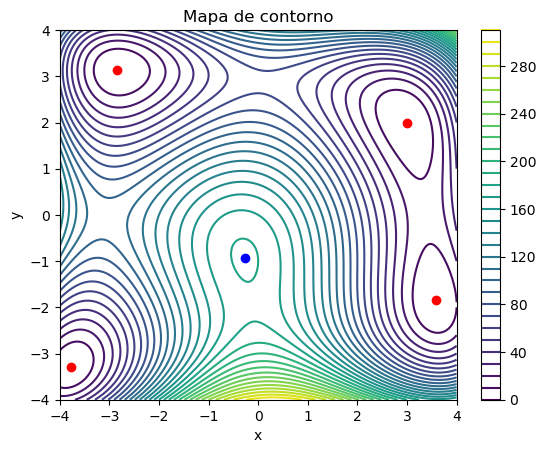

In [20]:
x = np.linspace(-4, 4, 1000)
y = np.linspace(-4, 4, 1000)
X, Y = np.meshgrid(x, y)
Z = himmelblau(X, Y)

plt.contour(X, Y, Z, levels=30) 
plt.colorbar() 
# Graficamos los mínimos
plt.scatter([3, -2.8505118, -3.779310, 3.584428], [2, 3.131312, -3.283186, -1.848126], color='red')
# Y el máximo
plt.scatter(-0.270845, -0.923039, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mapa de contorno')
plt.show()

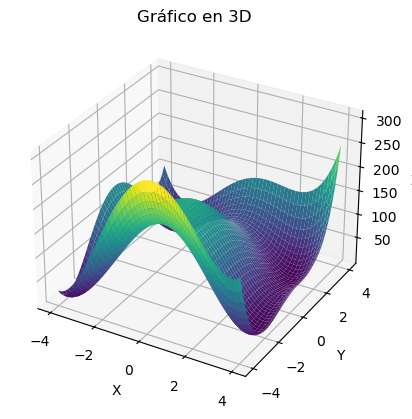

In [21]:
# Grafiquemos en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficamos la superficie
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Gráfico en 3D')
plt.show()

### Gradiente descendiente usando el gradiente calculado

Empecemos calculando el gradiente descendiente en la función de Himmelblau,

$$\nabla f = \left( \frac{\partial f}{\partial x},  \frac{\partial f}{\partial x} \right) = \left( 4x(x^2 + y - 11) + 2(x + y^2 - 7), 2(x^2 + y - 11) + 4y(x + y^2 - 7) \right)  $$

Pasemos el gradiente a una función de Python:

In [22]:
def grad_himmelblau(x, y):
    return 4*x*(x**2 + y - 11) + 2*(x + y**2 - 7), 2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)

Con esto vamos a usar gradiente descendiente, para esto debemos usar la siguiente fórmula:

$$ X_{new} = X - \alpha \nabla f(X) $$

Este método nos pide que definamos a alfa, para este caso vamos a usar un número constante, pero se puede aplicar otras variantes como empezar con un valor 
grande, lo cual va a generar pasos grandes iniciales, y luego vamos disminuyendo.

In [23]:
alpha = 0.005

max_iteration = 1000

# Iniciamos en un punto específico a modo didáctico, pero en general, se arranca en un valor al azar.
x_new = -2.4169722739821795 
y_new = -2.3589966623281526
f_new = himmelblau(x_new, y_new)

evolution_pos = [(x_new, y_new)]
evolution_value = [f_new]

for iteration in range(max_iteration):
    
    # Calculamos el gradiente en el punto
    delta_x, delta_y = grad_himmelblau(x_new, y_new)
    
    # Movemos en la dirección contraria a gradiente
    x_new -= alpha*delta_x
    y_new -= alpha*delta_y
    f_new = himmelblau(x_new, y_new)
    
    evolution_pos.append((x_new, y_new))
    evolution_value.append(f_new)
    
    # Dado que estamos en un espacio continuo, no podemos cortar cuando el gradiente es cero,
    # ya que es prácticamente imposible que esto ocurra (por errores numéricos).
    # Por lo que si lo que varía es menor a 10^-30, cortamos.
    if delta_x < 1e-12 and delta_x < 1e-12:
        break
        
print(f"Un minimo se encuentra en {(x_new, y_new)}")
print(f"Llevo {iteration} iteraciones")

Un minimo se encuentra en (-3.7793102533777407, -3.2831859912861594)
Llevo 76 iteraciones


Grafiquemos la evolución del algoritmo de gradiente, el cual vemos en el siguiente diagrama de contorno como el circulo rojo arranca en una posición y va 
cayendo a uno de los mínimos.

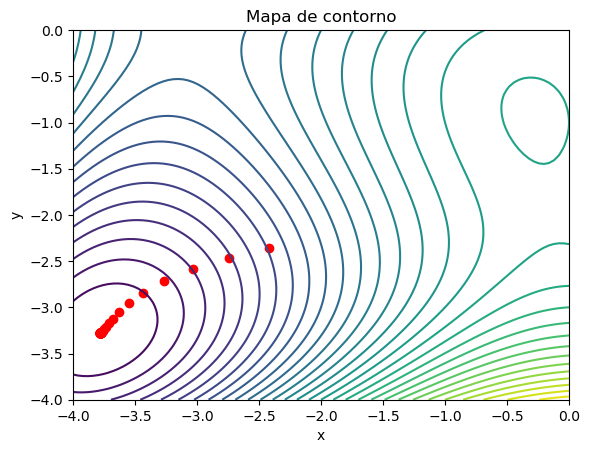

In [24]:
x = np.linspace(-4, 0, 100)
y = np.linspace(-4, 0, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau(X, Y)

plt.contour(X, Y, Z, levels=30)
for search_coords in evolution_pos:
    plt.scatter(search_coords[0], search_coords[1], color='red')
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mapa de contorno')
plt.show()

El problema es que hay veces que no podemos calcular el gradiente, en esos casos usamos algún método aproximado. 

En este caso vamos a usar a estimar las derivadas del gradiente usando un esquema *de diferencia central*:


In [25]:
def graf_himmelblau_estimated(x, y, delta_x, delta_y):
    
    f_x_up = himmelblau(x + delta_x, y)
    f_x_down = himmelblau(x - delta_x, y)
    
    f_y_up = himmelblau(x, y + delta_y)
    f_y_down = himmelblau(x, y - delta_y)
    
    # Calculamos la derivada parcial para cada variable usando diferencia central
    return (f_x_up - f_x_down) / 2*delta_x, (f_y_up - f_y_down) / 2*delta_y

In [26]:
alpha = 0.01

max_iteration = 1000

# Iniciamos en un punto específico a modo didáctico, pero en general, se arranca en un valor al azar.
x_new = -2.4169722739821795 
y_new = -2.3589966623281526

delta_x_upwind = 0.1
delta_y_upwind = 0.1

f_new = himmelblau(x_new, y_new)

evolution_pos = [(x_new, y_new)]
evolution_value = [f_new]

for iteration in range(max_iteration):
    
    # Calculamos el gradiente en el punto
    delta_x, delta_y = graf_himmelblau_estimated(x_new, y_new, delta_x_upwind, delta_y_upwind)
    
    # Movemos en la dirección contraria a gradiente
    x_new -= alpha*delta_x
    y_new -= alpha*delta_y
    f_new = himmelblau(x_new, y_new)
    
    evolution_pos.append((x_new, y_new))
    evolution_value.append(f_new)
    
    # Dado que estamos en un espacio continuo, no podemos cortar cuando el gradiente es cero,
    # ya que es prácticamente imposible que esto ocurra (por errores numéricos).
    # Por lo que si lo que varía es menor a 10^-30, cortamos.
    if delta_x < 0.0001 and delta_x < 0.0001:
        break
        
print(f"Un minimo se encuentra en {(x_new, y_new)}")
print(f"Llevo {iteration} iteraciones")

Un minimo se encuentra en (-3.7761281994632294, -3.2788939297106943)
Llevo 999 iteraciones


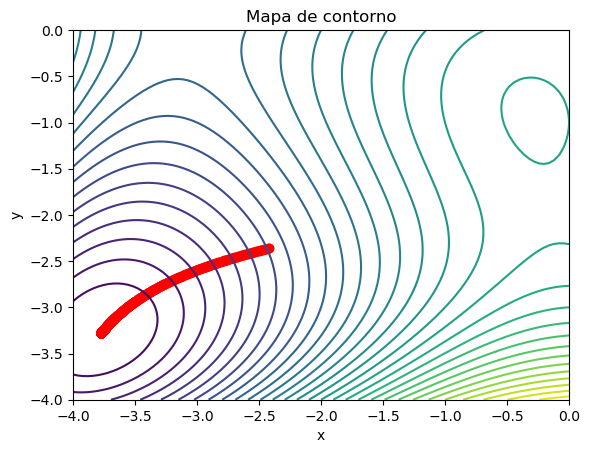

In [27]:
x = np.linspace(-4, 0, 100)
y = np.linspace(-4, 0, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau(X, Y)

plt.contour(X, Y, Z, levels=30)
for search_coords in evolution_pos:
    plt.scatter(search_coords[0], search_coords[1], color='red')
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mapa de contorno')
plt.show()

Aquí vemos la desventaja, con el gradiente llegamos en muchos menos pasos y fuimos muchos más precisos, en cambio, al usar un método numérico para el 
gradiente, el proceso fue más lento. La ventaja es que no requiere de saber la derivada, e inclusive se puede trabajar con arrays de valores directos en los
casos que no se conoce la función.

Nota: Se deja a los alumnos la implementación de derivada direccional y por consiguiente la implementación de un gradiente descendiente estocástico o de simulated annealing.